# **MIE1624 Group 19 Course Project**

## **1. Prep**

### a. Import Packages and get data file ready

In [1]:
!python -m spacy download en_core_web_sm > /dev/null 2>&1
!pip install spacytextblob > /dev/null 2>&1
!pip install tqdm_notebook > /dev/null 2>&1

In [2]:
import html
import numpy as np
import os
import pandas as pd
import pickle
import re
import spacy
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Reshape
from keras.wrappers.scikit_learn import KerasRegressor
from keras.optimizers.schedules import ExponentialDecay
from keras.optimizers import Adam

from sys import platform
from spacytextblob.spacytextblob import SpacyTextBlob

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.compose import ColumnTransformer
from sklearn.base import TransformerMixin

from tensorflow.keras.callbacks import EarlyStopping

from joblib import dump, load

if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  from tqdm.notebook import tqdm_notebook as tqdm
  drive.mount('/content/drive')

  base_data_folder = "/content/drive/MyDrive/Colab Notebooks/data/"
  train_data = pd.read_csv(base_data_folder + "train.csv")
  test_data = pd.read_csv(base_data_folder + "test.csv")
  rating_pairs_path = base_data_folder + "rating_pairs.csv"
  rating_pred_export_path = base_data_folder + "rating_pairs_pred.csv"
else:
  from tqdm import tqdm
  data = pd.read_csv("./data.csv", index_col=0)
  test_data = pd.read_csv("./test_data.csv", index_col=0)
  rating_pairs_path = "./rating_pairs.csv"
  rating_pred_export_path = "./rating_pairs_pred.csv"

tqdm.pandas()

Mounted at /content/drive


/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


### b. Understanding Data

In [3]:
train_data.head()

,overall,reviewTime,reviewerID,reviewText,summary,unixReviewTime,category,price,itemID,reviewHash,image
0,5.0,"08 26, 2014",u92990698,A contemporary jazz and soul performer who's m...,""" CLASSIQUE """,1409011200,Jazz,$8.40,p23649501,3856620,NaN
1,5.0,"05 11, 2003",u36200649,Very good idea to put both the 'pop' and 'orch...,Exceeded my Expectations - This album RAWKS!,1052611200,Alternative Rock,$10.98,p58458313,56086781,NaN
2,5.0,"12 5, 2017",u10721702,This is a great collection of Carole King's so...,A Must-have for Carole King Fans,1512432000,Pop,$5.99,p97027626,55852154,NaN
3,5.0,"09 24, 2013",u86003775,The is album is a brilliant piece of Jazz fusi...,A Master piece!,1379980800,Jazz,$14.64,p43167086,43228100,NaN
4,5.0,"01 14, 2015",u25672859,Waited a LONG time for this DVD to be released...,especially if you like concert videos,1421193600,Alternative Rock,$9.92,p94494236,54425467,NaN


In [4]:
test_data.head()

,reviewTime,reviewerID,reviewText,summary,unixReviewTime,category,price,itemID,reviewHash,image
0,"02 11, 2017",u04140621,ok,Five Stars,1486771200,Pop,$31.20,p65721979,98944233,NaN
1,"01 29, 2018",u74766187,The 1955 and 1958 sets alone are worth the pur...,Buy It For the 1955 Set With Monk!,1517184000,Jazz,$34.04,p87809670,33903910,NaN
2,"08 29, 2005",u31689638,Mary J Blige is someone most people know of. S...,Mary's excellent debut! Classic!,1125273600,Pop,$1.72,p52702240,35386470,NaN
3,"11 2, 2015",u35613516,Very good satch album,Four Stars,1446422400,Pop,$10.99,p01314374,12404766,NaN
4,"01 3, 2012",u93320378,Well there are hundreds of Christmas anthologi...,CD lives up to its name,1325548800,Alternative Rock,$7.98,p84396269,68253688,NaN


In [5]:
print(f'training set shape: {train_data.shape}')
print(f'testing set shape: {test_data.shape}')

training set shape: (150000, 11)
testing set shape: (20000, 10)


In [6]:
print(f'Number of reviewText nan in training set: {train_data.reviewText.isna().sum()}')
print(f'Number of reviewText nan in testing set: {test_data.reviewText.isna().sum()}')

Number of reviewText nan in training set: 28
Number of reviewText nan in testing set: 3


## **2. Data Cleaning**

### a. Handle null value

In [7]:
train_data.fillna('', inplace=True)
test_data.fillna('', inplace=True)

### b. Replace character codes


In [8]:
def replace_character_codes(text):
    text = html.unescape(text)
    return text

### c. Remove url


In [9]:
def remove_url(text):
    text =  re.sub(r"https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)", "", text)
    return text

### d. Remove dollar sign in price, also handle string case

In [10]:
def handle_price(price):
  try:
    return float(re.sub('[$]+', '', price))
  except:
    return 0

### e. Combine reviewID, itemID and reviewText

In [11]:
def combine_feature(data):
  return ' '.join(data)

### f. Keep only the year of review time

In [12]:
def handle_year(year):
  return int(year[-4:])

### g. Remove stop words

In [ ]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', \
                "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', \
                'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", \
                'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', \
                'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', \
                'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', \
                'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
                'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', \
                'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', \
                'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', \
                'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'only', \
                'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", \
                'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", \
                'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', \
                "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', \
                "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", \
                'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"])

# ref: https://gist.github.com/sebleier/554280
# above stop words were used to remove any words that are not useful/influential for sentiment analysis/prediction. The above list/set is not conclusive by any means but it contains enough to simplify our model inputs

# data cleaning function that ensures that unnecssary elements are exluded from the journey of predicting sentiments. In the process, hashtags and mentions are removed, which could have been useful in a simpler stratefy implemented in exploratory analysis 
def clean_text(text):
  soup = BeautifulSoup(text, 'lxml') 
  text = soup.get_text() # gets rid of html tags  
  t = re.sub('^', '', text) #gets rid of the attribute '^' by replacing with space
  t = re.sub('[+]', '', t) # gets rid of the attribute '+' 
  t = re.sub('[/]', '', t) # gets rid of the attrubute '/'
  t = re.sub('[<>]', '', t) # gets rid of the attributes '<>'
  t = re.sub('[^A-Za-z0-9]+', ' ', t) # gets rid of any special charachters like #, @, -, etc. This is to make sure data is in its basic elements to ease the classification of tweet's political party in the next step 
  t = html.unescape(t) # replaces HTML charachter codes with ASCII equivalent
  t = re.sub(r"http\S+", "", t) # removes URL links
  t = t.lower() # normalizes the tweets to be all as lower case
  t = ' '.join(e.lower() for e in t.split() if e.lower() not in stopwords) # removes stopwords that are in the set defined above and replaces it with space
  return t

### g. Process Step

In [13]:
def clean_data(data):
  data['cleaned_reviewText'] = data['reviewText'].progress_apply(replace_character_codes)
  data['cleaned_summary'] = data['summary'].progress_apply(replace_character_codes)

  data['cleaned_reviewText'] = data['cleaned_reviewText'].progress_apply(remove_url)
  data['cleaned_summary'] = data['cleaned_reviewText'].progress_apply(remove_url)
    
  data['cleaned_reviewText'] = data['cleaned_reviewText'].progress_apply(clean_text)
  data['cleaned_summary'] = data['cleaned_reviewText'].progress_apply(clean_text)
  
  data['price'] = data['price'].progress_apply(handle_price)
  data['year'] = data['reviewTime'].progress_apply(handle_year)
    
  data['combined_reviewText'] = data[['reviewerID', 'itemID', 'cleaned_reviewText']].progress_apply(combine_feature, axis=1)

clean_data(train_data)
clean_data(test_data)

### h. Drop unused data

In [14]:
def drop_unused(data):
  data.drop(columns=['reviewerID', 'reviewTime', 'reviewText', 'summary', 'unixReviewTime', 'itemID', 'reviewHash', 'image', 'cleaned_reviewText'], inplace=True)

In [15]:
drop_unused(train_data)
drop_unused(test_data)

## **3. Feature Engineering**

### a. Categorize category and year

In [16]:
def categorize(data):
  dummy_years = pd.get_dummies(data.year, prefix='year')
  dummy_categories = pd.get_dummies(data.category, prefix='category')
  data = pd.concat([data, dummy_years, dummy_categories], axis=1)
  data.drop(columns=['year', 'category'], inplace=True)
  return data

train_data = categorize(train_data)
test_data = categorize(test_data)

### b. reindex test data

In [17]:
test_data.reindex(columns=train_data.drop(columns=['overall']).columns)

,price,cleaned_summary,combined_reviewText,year_1998,year_1999,year_2000,year_2001,year_2002,year_2003,year_2004,year_2005,year_2006,year_2007,year_2008,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,category_Alternative Rock,category_Classical,category_Dance & Electronic,category_Jazz,category_Pop
0,31.20,ok,u04140621 p65721979 ok,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,34.04,The 1955 and 1958 sets alone are worth the pur...,u74766187 p87809670 The 1955 and 1958 sets alo...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2,1.72,Mary J Blige is someone most people know of. S...,u31689638 p52702240 Mary J Blige is someone mo...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,10.99,Very good satch album,u35613516 p01314374 Very good satch album,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
4,7.98,Well there are hundreds of Christmas anthologi...,u93320378 p84396269 Well there are hundreds of...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,11.87,"My goodness, Christian Scott has simply taken ...","u16765812 p17291597 My goodness, Christian Sco...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
19996,16.99,Congratulations Clan of Xymox - You have butch...,u04428712 p73630774 Congratulations Clan of Xy...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
19997,49.95,I'm so happy that all of Cher's videos are out...,u39251384 p58275451 I'm so happy that all of C...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
19998,9.42,While I agree with the comments made by Maxwel...,u05089888 p13155723 While I agree with the com...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


### c. Save processed data

In [18]:
train_data.to_csv(base_data_folder + 'train_processed.csv', index=False)
test_data.to_csv(base_data_folder + 'test_data.csv', index=False)

## **4. Visualization**

In [19]:
!pip install --force-reinstall --no-deps git+https://github.com/ck37/coral-ordinal/ > /dev/null 2>&1

In [20]:
import coral_ordinal as coral
import pickle
import scipy
import tensorflow as tf

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import *
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score, train_test_split, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC, LinearSVR
from sklearn.tree import DecisionTreeClassifier

from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LSTM, Reshape
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor

In [21]:
train_data = pd.read_csv(base_data_folder + 'train_processed.csv')
test_data = pd.read_csv(base_data_folder + 'test_data.csv')
train_data.fillna("", inplace=True)
test_data.fillna("", inplace=True)

### a. rating distribution

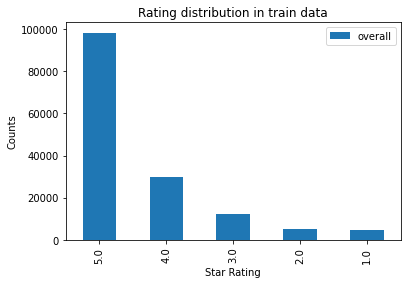

In [37]:
overall_df = pd.DataFrame(train_data['overall'].value_counts())
overall = overall_df.plot.bar()
plt.xlabel('Star Rating')  
plt.ylabel('Counts')
plt.title('Rating distribution in train data')
plt.show()

### b. word analyzation

In [ ]:
# for wrods analyzation based on preproced_text
# import itertools
# import nltk
# nltk.download('punkt') 

In [38]:
# for wrods analyzation based on preproced_text
# import itertools
# import nltk
# nltk.download('punkt') 
# top_N = 20
# preproced_trai_sent = train_data['combined_reviewText'].str.cat(sep=' ')
# words = nltk.tokenize.word_tokenize(preproced_trai_sent)
# words_selected = [i for i in words if len(i) > 2]
# words_dist = nltk.FreqDist(words_selected)
# words_fre = pd.DataFrame(words_dist.most_common(top_N),
#                     columns=['Word', 'Frequency'])
# words_fre

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


,Word,Frequency
0,the,853275
1,and,531119
2,this,236160
3,that,215149
4,with,159400
5,The,151570
6,album,150895
7,for,134245
8,you,125876
9,are,123199


## **5. Models**

### a. prep

### b. Simple Models

##### convert sparse matrix to dense

In [23]:
class DenseTransformer(TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()

##### Train

In [ ]:
max_iter = 100
max_features=2000
n_gram = 2
models = {
    'Logistic Regression': LogisticRegression,
    'Naive-Bayes': GaussianNB,
    'SVM': SVC,
    'Decision Tree': DecisionTreeClassifier,
    'Random Forest': RandomForestClassifier,
    'XGBoost': GradientBoostingClassifier
}

vectorizers1 = {
    'wf': CountVectorizer(),
    'tfidf': TfidfVectorizer(),
    '2gram': CountVectorizer(analyzer='word', ngram_range=(2, 2))
}

vectorizers2 = {
    'wf': CountVectorizer(),
    'tfidf': TfidfVectorizer(),
    '2gram': CountVectorizer(analyzer='word', ngram_range=(2, 2))
}

def test_models(data,
                test_size=0.3,
                max_iter=max_iter, 
                max_features=max_features, 
                models=models, 
                vectorizers1=vectorizers1,
                vectorizers2=vectorizers2,
                verbose=False
                ):
  y = data.overall
  X = data.drop(columns=['overall'])
  for vc1_name, vc1 in vectorizers1.items():
    for vc2_name, vc2 in vectorizers2.items():
      for model_name, model in models.items():
        try:
          m = model(max_iter=max_iter)
        except:
          m = model()

        summary_pipe = Pipeline([
                                 ('vect', vc1),
                                 ('select', SelectKBest(chi2, k=max_features))
                                 ])

        review_pipe = Pipeline([
                                ('vect', vc2),
                                ('select', SelectKBest(chi2, k=max_features))
                                ])
        
        preprocess = ColumnTransformer([
                                        ('price_std', StandardScaler(), ['price']),
                                        ('summary', summary_pipe, 'cleaned_summary'),
                                        ('reviewText', review_pipe, 'combined_reviewText')
                                        ], remainder = 'passthrough')
        
        pipe = Pipeline([
                        ('preprocess', preprocess),
                        ('to_dense', DenseTransformer()),
                        ('model', m)
        ])
        
        y = data.overall
        X = data.drop(columns=['overall'])
        
        X_train, X_test, y_train, y_test = train_test_split(X,
                                                      y,
                                                      test_size=test_size, 
                                                      random_state=42)

        pipe.fit(X_train, y_train)

        prediction = pipe.predict(X_test)
        error = mse(y_test, prediction)
        print(f'===== {model_name} | review text vectorizer: {vc1_name} | summary vectorizer: {vc2_name} =====')
        print(f'Test Mean Squared Error: {error}')

test_models(train_data)

### **c. Neural Network**

We use a pipeline for our neural network model and it consists following steps: 

1.   The model uses column transformer to process the features separately. It normalizes the numeric features and vectorizes the text feature using TFIDF. We also use feature selection to select the best features for the text features.
2.   It transforms the sparse matrix produced by the column transformer to dense matrix in order to feed in the neural network.
3. The NN consists of a LSTM along with a few more dense layers and we use it to predict the overall rating.

#### 1) Helper functions

1. Create model

2. Model tuner

In [24]:
def create_model(num_layer=256, 
                 init_lr=0.005, 
                 decay_rate=0.95, 
                 decay_step=3000, 
                 drop_out=0.75,
                 epoch=50,
                 batch_size=64,
                 saved_features=2000,
                 vectorizer='tfidf'):
  def model_compiler(
      num_layer=num_layer,
      init_lr=init_lr,
      decay_rate=decay_rate,
      decay_steps=decay_step,
      drop_out=drop_out,
      loss_func='mse',
      metrics = [tf.keras.losses.MSE],
      saved_features=saved_features
      ):
    model = tf.keras.Sequential([
      Reshape(target_shape=(1,-1)),
      LSTM(num_layer),
      Dropout(drop_out),
      Dense(num_layer*2, kernel_initializer='normal', activation='relu'),
      Dropout(drop_out),
      Dense(num_layer, kernel_initializer='normal', activation='relu'),
      Dropout(drop_out),
      Dense(num_layer/2, kernel_initializer='normal', activation='relu'),
      Dropout(drop_out),
      Dense(1, kernel_initializer='normal', activation='relu')
    ])
    # decay learning rate
    lr_schedule = ExponentialDecay(
        initial_learning_rate=init_lr,
        decay_steps=decay_steps,
        decay_rate=decay_rate,
        staircase=True)

    opt = Adam(learning_rate=lr_schedule)
    model.compile(loss=loss_func, optimizer=opt, metrics=metrics)
    return model

  vects = {
    'wf': CountVectorizer(),
    'tfidf': TfidfVectorizer(),
    '2gram': CountVectorizer(analyzer='word', ngram_range=(2, 2))
  }
  vect = vects[vectorizer]
  summary_pipe = Pipeline([
                      ('vect', vect),
                      ('select', SelectKBest(chi2, k=saved_features))
                      ])

  review_pipe = Pipeline([('vect', vect),
                          ('select', SelectKBest(chi2, k=saved_features))
                                ])

  preprocess = ColumnTransformer([
                                ('price_std', StandardScaler(), ['price']),
                                ('summary_count_vec', summary_pipe, 'cleaned_summary'),
                                ('review_tfidf', review_pipe, 'combined_reviewText')
                                ], remainder = 'passthrough')
  model = KerasRegressor(model_compiler, epochs=epoch, batch_size=batch_size, verbose=True)
  pipe = Pipeline([('preprocess', preprocess),
                    ('to_dense', DenseTransformer()),
                    ('nn', model)], verbose=True)
  return pipe

In [25]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
class ModelTuner():
  def __init__(self, params):
    self.params = params
    self.models = [create_model(**param, epoch=15) for param in self.params]
    self.train_scores = [0] * len(self.params)
    self.test_scores = [0] * len(self.params)

  def fit_scores(self, X_train, y_train, X_test, y_test):
    for i, model in enumerate(self.models):
      model.fit(X_train, y_train)
      y_train_pred = model.predict(X_train)
      y_pred = model.predict(X_test)
      self.test_scores[i] = mean_squared_error(y_test, y_pred)
      self.train_scores[i] = mean_squared_error(y_train, y_train_pred)
  
  def visualize(self, title, xlabel):
    width = 0.35  # the width of the bars
    x = np.arange(len(self.train_scores))
    params = [list(param.values())[0] for param in self.params]

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, self.train_scores, width, label='Train')
    rects2 = ax.bar(x + width/2, self.test_scores, width, label='Test')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('MSE')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(params)
    ax.set_xlabel(xlabel)
    ax.legend()

    plt.show()

In [31]:
y = train_data.overall
X = train_data.drop(columns=['overall'])
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                      test_size=0.3, 
                                                      random_state=42)

#### 2) Tuning Learning Rate

In [ ]:
y = train_data['overall']
X = train_data.drop(columns=['overall'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
lr_tuner = ModelTuner(params=[{'init_lr': 0.05},
                              {'init_lr': 0.01},
                              {'init_lr': 0.005}])

lr_tuner.fit_scores(X_train, y_train, X_test, y_test)

##### Visualization

In [ ]:
lr_tuner.visualize("Initial learning rate VS MSE", "Initial learning rate")

In [ ]:
# Delete the model to free memory
del lr_tuner

#### 3) Tune Number of Layers

In [ ]:
layer_tuner = ModelTuner(params=[{'num_layer': 128},
                                 {'num_layer': 256},
                                 {'num_layer': 324}
                                ])
layer_tuner.fit_scores(X_train, y_train, X_test, y_test)

##### Visualiztion

In [ ]:
layer_tuner.visualize("Number of Layers VS MSE", "Num of layers")

In [ ]:
del layer_tuner

#### 4) Tune Batch Size

In [ ]:
batch_tuner = ModelTuner(params=[{'batch_size': 32},
                                 {'batch_size': 64},
                                 {'batch_size': 128}
                                ])
batch_tuner.fit_scores(X_train, y_train, X_test, y_test)

##### Visualization

In [ ]:
batch_tuner.visualize("Batch size VS MSE", "Batch size")

In [ ]:
del batch_tuner

#### 5) Tune feature representation

In [33]:
vect_tuner = ModelTuner(params=[{'vectorizer': 'wf'},
                                 {'vectorizer': 'tfidf'},
                                 {'vectorizer': '2gram'}
                                ])
vect_tuner.fit_scores(X_train, y_train, X_test, y_test)

[Pipeline] ........ (step 1 of 3) Processing preprocess, total=  22.7s
[Pipeline] .......... (step 2 of 3) Processing to_dense, total=   1.8s
Epoch 1/15
1641/1641 [==============================] - 25s 5ms/step - loss: 2.8694 - mean_squared_error: 2.8694
Epoch 2/15
1641/1641 [==============================] - 8s 5ms/step - loss: 0.9853 - mean_squared_error: 0.9853
Epoch 3/15
1641/1641 [==============================] - 8s 5ms/step - loss: 0.9008 - mean_squared_error: 0.9008
Epoch 4/15
1641/1641 [==============================] - 8s 5ms/step - loss: 0.9325 - mean_squared_error: 0.9325
Epoch 5/15
1641/1641 [==============================] - 8s 5ms/step - loss: 0.9841 - mean_squared_error: 0.9841
Epoch 6/15
1641/1641 [==============================] - 8s 5ms/step - loss: 0.9914 - mean_squared_error: 0.9914
Epoch 7/15
1641/1641 [==============================] - 7s 5ms/step - loss: 1.0089 - mean_squared_error: 1.0089
Epoch 8/15
1641/1641 [==============================] - 7s 5ms/step - los

##### Visualization

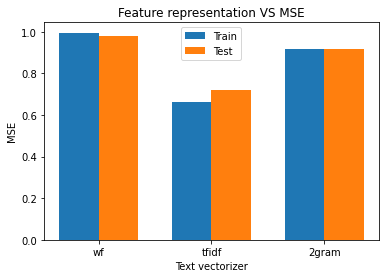

In [34]:
vect_tuner.visualize("Feature representation VS MSE", "Text vectorizer")

In [ ]:
del vect_tuner

#### 5) Fit the model on partial training data and validate

In [ ]:
def model_test(model, X_test, y_test):
  y_pred = model.predict(X_test)
  score = mse(y_test, y_pred)
  return score

pipe = create_model(batch_size=64, num_layer=256, init_lr=0.005, vectorizer="tfidf")
pipe.fit(X_train, y_train)

As we can see, the model is still a bit overfitted although we already did feature selection, learning rate decay and hyperparameter tuning.

In [ ]:
train_score = model_test(pipe, X_train, y_train)
test_score = model_test(pipe, X_test, y_test)
print(f"Training MSE: {train_score}")
print(f'Testing MSE: {test_score}')

#### 6) Fit the model on all training data

Train the model using all data with best hyperparameters:
batch_size=64, num_layer=256, init_lr=0.005, vectorizer='tfidf'



In [ ]:
pipe = create_model(batch_size=64, num_layer=256, init_lr=0.005, vectorizer="tfidf")
pipe.fit(X, y)
predictions = pipe.predict(test_data)
# clip the data between the range of the reviews
predictions = np.clip(predictions, a_min=1.0, a_max=5.0)

In [ ]:
score = model_test(pipe, X, y)
print(f"Training MSE: {score}")

In [ ]:
def export_to_kaggle(rating_pairs_path, predictions, export_path):
  rating_pairs = pd.read_csv(rating_pairs_path)
  rating_pairs['prediction'] = predictions
  rating_pairs.to_csv(export_path, index=False)

In [ ]:
export_to_kaggle(rating_pairs_path, predictions, rating_pred_export_path)